# AI Game Playing Algorithms with Checkers

Ryan Williams, Ben Newell, Chris Haynes

## Introduction

For this project, we decided to use different AI game playing algorithms on checkers to see which ones play the best. For the rules of checkers, visit [this website](https://www.itsyourturn.com/t_helptopic2030.html). We chose the following four game playing algorithms: minimax, negamax, reinforcement learning with temporal difference and reinforcement learning with a neural network. Additionally, we created a board python class to represent the board for the game handling all of the game playing mechanics like picking a valid move, making a move, determining if the game is over, etc. After implementation, we proceeded to run the algorithms against opponents who choose random moves and then the other game playing algorithms to see which one would come out on top.

The dividing of the workload was done as follows:
* Ryan Williams - Minimax and Negamax
* Ben Newell - Reinforcement learning with a neural network
* Chris Haynes - Board class, Piece class, and reinforcement learning with temporal difference

## Methodology

## Necessary Imports and definitions

In [14]:
inf = float('infinity')
from board import Board
from piece import Color, Piece
from negamax import negamax
from minimax import minimax
import neuralnetworks as nr
from NeuralReinforcement import *
from reinforcement import *
from scaledconjugategradient import *
from test import *
from copy import copy, deepcopy
import numpy as np

ModuleNotFoundError: No module named 'dill'

## Board Class
### Overview
This class contains the entire functionality of checkers. It handles everything required to turn the game of checkers into a trainable game for the different AI algorithms. The functions that we have learned throughout the semester that are quintessential to many algorithms, such as `stateMoveTuple`, `validMoves`, etc. all reside in the board class. Since the class is very large, the functions will be described in the order they appear to make it easier to understand. 

### Functions

#### Constructor: `__init__(self)`
This function initializes the game of checkers. It uses an 8x8 numpy array called `draught` (the official name of the checkers board) of `Piece` objects to initialize the board. If a piece is absent, the space is set to `None`. Initial positions are the first three and last three rows and alternate between a left alignment and right alignment. Since the color red starts the game, the turn is set to `Color.RED`, where color is an enumeration. This could have been simplified to a boolean saying `red_turn = True` for red's turn and `red_turn = False` for black's turn. However for readability of my teammates I added the enumeration.

#### Representation: `__repr__(self)`
This function converts a board to a string so it is easier to print and make `stateMoveTuples`. It creates a format string that represents a row, and for every row add the `Piece` string representation and if it is `None` add a dash to represent the empty space. It has indexed columns and rows that correspond to the indices of the numpy array `draught`.

#### Print State: `printState(self)`
This function prints a board, which calls the `__repr__` function described earlier.

#### State Move Tuple: `stateMoveTuple(self, move)`
This function takes a move as input and returns a tuple with the state of the board as a string and a move (which is already a tuple).

#### Make Move: `makeMove(self, move)`
This function takes a move and will make a move on the board. It uses the length of the move tuple to determine if any jumps occur during the move. If a jump is made, the pieces that were jumped during the move are set to `None` in the `draught`. It will then set the pieces previous space to `None` and update the space that it is moving to with moved `Piece`. If a `Piece` has reached the opponents edge of the `draught`, the `Piece` will be promoted to a king. The turn is then changed.

#### Change Turn: `changeTurn(self)`
This changes the turn of the board using a ternary operator to determine which turn to set the `Board` to the correct turn.

#### Valid Moves: `validMoves(self)`
This function determines the list of valid moves for a `Board` based on the turn. It begins by filtering for the `valid_pieces` on the `Board`. An array is initialized to hold all `valid_moves`. For every piece in the `valid_pieces` it checks if it can move left or right based on its color if it is not a king. So black can move up in rows and red can move down. Kings can move in all directions. This uses the `checkSpace` helper function to determine legal moves in that direction. It filters out the moves returned and adds it to the array it returns in the tuple format of `(initial position, move)`. For multiple jumps, they are recorded in the move. 

#### Check Space: `checkSpace(self, position, row_mod, col_mod, king=False, recurse=False, positions=None)`
This function takes as input an initial position, directions to move, whether or not the piece is a king, and recursion arguments. It starts by getting the `new_row` and `new_col` for a space to check. If it is in bounds, a check is performed to see if it is unoccupied. If it is, and it's not recursing (which happens during a jump), it will return that position only since it is an unoccupied space. If it is occupied and can be jumped and hasn't already been added to a jump pattern, it will check for extra jumps by checking the left and right positions again recursively. For kings it checks three positions instead of four (in `validMoves` it uses four) because a piece may not be jumped twice. If more jumps are found, they are added to the move. Return the list of valid moves.

#### Can Be Jumped: `canBeJumped(self, attacker, defender)`
Checks if a piece can be jumped. It takes as input an attacking position and a defending position. The massive if statement determines the direction of the attack and if the piece has no piece on the other side of a jump, it may be jumped and will return `True`. In the case that it cannot be jumped, it will return `False`. 

# Piece Class
## Overview
This class represents a `Piece` on the `Board` in the `Board.draught` array. The class is fairly simple, but contains data critical to a `Piece`'s functionality in the game.

## Functions

#### Constructor: `__init__(self, color, initial_position)`
The constructor take as input the `Color` of the `Piece`, and it's `initial_position` on the board, which is a tuple in the form of (row, column). It is initialized as a normal piece rather than a king, so `king = False`. 

#### Representation: `__repr__(self)`
This is the string function for a `Piece`. It is the `Color` of the piece as a character ('B' for `Color.BLACK` and 'R' for `Color.RED`. If it is a king, a 'K' is appended to the string. So a red king is represented as 'RK' instead of just 'R'.

#### King Me: `king_me(self)`
Promotes a `Piece` to king by setting `Piece.king` to `True`. 

# Reinforcement 
## Overview
Notice that this is not a class like `Board` and `Piece` but rather just functions. These functions will both train and use a `Q` dictionary that stores the a `Board` state move tuple as the key to a number that represents the potential game outcome of making that particular move for that exact scenario. The higher the number, the better that move is for the AI. Our reinforcement is a little bit different than the reinforcement learning we saw in class. This algorithm back propagates a reinforcement throughout every move that led to that state, so that moves early in the game still recieve a value. Also, we significantly reduce the size of the `Q` table by storing just moves, rather than a state move tuple. Checkers has 500 billion billion possible states, not including state move tuples. We aslo did this because moves hold interesting information about the game, such as jumping another piece, getting kinged, etc. due to the way they are represented in the board class, and so that AI can extrapolate the usefulness of the move based on the outcome of the game.

## Functions

#### Epsilon Greedy: `epsilonGreedy(epsilon, Q, board)`
This function selects a move for a board based on an epsilon to add randomness into the selection. It takes an `epsilon` and will choose either a random move if a randomly generated number is less than the `epsilon`. The process is that a list of valid moves is generated for a `Board`. If the random route is selected, the a random move from `valid_moves` is selected. Otherwise, the greedy move for the `Q` dictionary is selected and returned.

#### Greedy: `greedy(valid_moves, Q, board)`
This function will make the greedy move for a board, or basically the move with the most utility as determined by the `Q` dictionary. For every move in `valid_moves`, if the state move tuple is in the dictionary, get its determined utility. Otherwise, it will be 0, a neautral utility because its usefulness has not yet been determined. It will then return the move with the highest utility. If all moves have the same value (most likely zero at the beginning), the first valid move will be chosen. For red this is the first move for the piece with the lowest row first, and lowest column second.

#### Finished: `finished(board)`
Determines if a game is finished. If the length of valid moves from the `board` is zero, the game is over.

#### Train Q: `trainQ(nRepititions, learningRate, epsilonDecayFactor, propagationDecayFactor)`
This function trains a `Q` dictionary for the number `nRepititions` games. The `learningRate` determines how fast the `Q` dictionary will learn for a certain move and board state. The `epsilonDecayFactor` determines the rate at which the `epsilon` passed to `epsilonGreedy` will decay, meaning using the utilities stored in the `Q` more and more. Every game is a new game, in which the AI is set to play as red. For every game, if the game is finished, update the dictionary with a reinforcement. If it is a win, that move will be represented by a 1. If it is a loss it will be -2. We selected -2 since it is playing a random opponent, and losing to a random move maker should be punished harsher than winning against that random player. After a move has been made, it will back propagate that move's utility throughout every move made that led up to it by calling `backPropagateReinforcement`.

#### Back Propagate Reinforcement: `backPropagateReinforcement(Q, move_tuple_list, learningRate, propagationDecayFactor)`
This function will back propagate a reinforcement through the Q dictionary. The reason we added this is there were too many zeros in the Q dictionary, and thus only first moves were selected a decent amount of the time as a result of np.argmax returning the first valid move when a move doesn't have a reinforcement. It back propagates a reinforcement throughout every move made that led to the final board state, so that every move has a reinforcement (every move matters!).

#### Use Q: `useQ(Q, maxSteps)`
This function tests the `Q` dictionary that results from the `trainQ` function. It uses the same game logic as `trainQ`. Red starts the game (red is the reinforcement trained AI). It makes a greedy move by calling `greedy` to determine the optimal move. Then black makes a random move and the game continues until one has lost. 

## Observations
There were some interesting observations along the way that led to structuring our reinforcement AI the way we did. First of all, we saw that using state move tuples worked just fine and the AI would beat the random with state move tuples as the keys to the `Q` dictionary. However, upon inspection there were way too many states and `Q` was very sparse after training, with often only values for less than 10% of all entries. 

The first method we tried to solve this was to back propagate the reinforcement with a very low decay rate so that the reinforcement would reach the opening move. However, these states were never used because there were too many to ever get a hit on the table. So how was that AI winning? Well, `numpy.argmax` in the `greedy` function takes the first valid move, so the strategy was inadvertantly to move the first piece possible up and to the left if it could, and never to move the last row. Since black could never move into the last row and make a king, it runs out of valid moves and the AI would win. 

To try and reduce this strategy and allow `Q` to actually contain some semblance of a strategy, we reduced `Q` to only contain the move selected. The move has inherent state involved, such as where it is moving from, the spaces it will jump, and the end position. This seemed to be enough to allow the AI to still ~98-99% of the time against a random opponent. This way we could look at the Q dictionary and see the values for the moves it selected. It still used the strategy of avoiding moving out of the back row if it could, but at times would jump a piece that had gotten close. It also really valued moving up the board as much as possible to try and get a king. If these moves were available they were often chosen, which could be a residual impact of the `numpy.argmax` usage we discussed earlier. Finally, it's winning strategy after observing many games. It tries it's best to get as many kings as possible, and leaves it's back row completely full, thus blocking the opponent from making any kings. Once it has kings and black has no kings, the opponent will inevitably run out of moves, and the AI will win the game.

#### Further Possible Research
Some interesting thoughts we had along the way and after discussing was using a smart test subject to train against. When looking at the moves made, the AI will take risks because a random opponent will rarely select the right move that would punish that risk, such as moving up the board and being vulnerable for a jump. It has one thing in mind: getting a king. To try and prevent foolish behavior such as this, a smarter training opponent could be added that would punish the AI by jumping it when it could. 

Another interesting idea is to use a neural net to determine the reinforcements. Possible reinforcements could be jumping pieces, getting kings, favoring the sides as opposed to the middle, and not moving off the back wall. If weights were determined through a neaural net for these reinforcements, the AI could be much smarter, and produce more accurate reinforcements for certain moves. 

Finally, we thought that it would be interesting to represent the keys to the `Q` dictionary in different ways. One could include a localized board section, where selecting the locally optimum would hopefully result in the global optimum. Another could be recognizing similar board patterns and using those patterns with move types (normal, jump, king, etc) as inputs into the dictionary. The point of changing how keys are represented is to reduce the number of states, while still maintaining a decently accurate `Q` dictionary.

## Adversarial Search

Checkers is a zero-sum game, meaning the payoff for each player at the end of the game is equal and opposite. For this reason, adversarial search algorithms like `minimax` and `negamax` can be used to play the game of checkers. Through a process similar to a depth first search, the algorithms search through each possible move from the initial player. Then, from each of these moves, the algorithm searches each move from there for the opposing player. Once the depth limit or leaf nodes are reached, the utility is returned and the player chooses the move that optimizes their utility. From there, in the next recursion up, that player chooses it's optimum move and so on. This process results in one of the key components of adversarial search algorithms, each player assumming the other is playing optimally. Both of the two adversarial search algorithms, `minimax` and `negamax` follow this same process. The way they differ is in how players' utility is determined, which will be explained below.

### Necessary funtions added to Board class

#### isOver

`isOver` determines if the game is over, and if it is, gives the winner. It does this by checking the valid moves for each player. If the player has no valid moves, they have lost and the other player is the winner. This can be done by taking all of the opposing pieces (no pieces mean no valid moves) or by trapping all of the opponents pieces so they cannot move. If both players have valid moves they can do, the game is not over yet so the function returns `False` for the result and `None` for the winner.

isOver(self)

Parameters:
* None

Return:
* boolean - true if game is over, false otherwise
* winner - RED or BLACK depending on the winner. If game is not over, value is None

#### getUtility

`getUtility` gets the utility for the calling player at the specific point in the game. If type is `nm` and the game is over, the function will return 2 if the calling player won and -2 if the calling player lost. If type is `mm`, however, the function will return 2 or -2 if the calling player won, 2 if it's the maximizer, -2 if it's the minimizer. If the calling player lost, -2 is returned if the caller is the maximizer and 2 is returned if the calling player is the minimizer.

If the game is not over, then a heuristic is used to determine utility. The number of red and black pieces are counted with kings counting as two. If the type is `nm`, Whichever color has more pieces is awarded a utility of 1 and the color with less pieces receives a utility of -1 . Of course, if the type is `mm`, then the utilities are slightly different, with 1 going to maximizer if it has more pieces and -1 going to minimizer if it has more pieces. Therefore, the maximizer will get a utility of -1 if it has less pieces and the minimizer will get 1 if it has less. Finally, if the number of pieces is equal, a utility of 0 is returned.

The utility function was made in this way so that winning supercedes all. At first, the thought was to use 1 as the utility for both winning and having more pieces, but we decided that it makes the most sense for the algorithm to choose the winning move if there is an option between that and merely having more pieces. The most simple way to do this was to set winning utility as greater than the heuristic so it would always be chosen.

getUtility(self, type='nm', maximizePlayer=Color.RED)

Parameters:
* type: 'mm' or 'nm' depending on whether the algorithm is `minimax` or `negamax` since they give different utilities to each player
* maximizePlayer: Color of the maximizing player

Return:
* integer - represents the utility given at this stage of the game

### Minimax

#### Algorithm

The two players in the minimax algorithm are `max` and `min`. `Max` will look to maximize the utility and `min` will look to minimize the utility. For our case, in our checkers implementation, a win for `max`is worth 2 and a win for `min` is worth -2. `Minimax` searches through every possible move in the game until the depth limit, assuming on the way that the opponent will play optimally. If the depth limit is reached, a simple heuristic is used to see who has the advantage. All of the pieces for each player will be counted, with kings counting as two. If `max` has more, a utility of 1 will be awarded; if `min` has more, however, a utility of -1 is awarded. 

One thing added to this algorithm to cut down run time was a `break` statement used if the returned utility is 2 for the maximizer or -2 for minimizer. This was done because these values signify a win for their respective player so there is no reason to search any other nodes on that level of the tree. Even though a win could be achieved with a different move yet to be searched from that state, the algorithm wouldn't even choose that path because the returned value would equal the `bestValue` but not be greater than it, so `bestValue` would not be updated anyway.

#### Alpha beta pruning

Alpha beta pruning is a technique used in adversarial search algorithms to limit the number subtrees that need to be searched. It does this by taking the best value found so far for one player, represented by the variable `alpha`, and comparing it to the best value found so far for the other player, represented by the variable `beta`. If `alpha` is ever greater than `beta`, all other subtrees at that level do not need to be searched and can be pruned because, even if they were to be searched, they would not be chosen by the algorithm. To explain further, even though the current node may have chosen a value in the pruned subtree, the node above the current is guarenteed to not choose anything in that subtree since it has already found a better value in a previous subtree. As a result, cutting off these subrees saves a lot of time.

The implementation of alpha beta pruning is simple for `minimax`. First, The parameters `alpha` and `beta` are added to the funtion with `alpha` always representing the best value for the maximizer and `beta` always representing the best value for the minimizer. Inside the function, if the current player is the maximizer, after a value and a move is returned by the recursive call to `minimax`, the current best value found is compared to `alpha`. If `bestValue` is greater than `alpha`, `alpha` will be set to `bestValue`. If the current player is the minimzer, however, the current best value is compared to `beta` and if `bestValue` is less than `beta`, `beta` is set to `bestValue`. Finally, following this process for both the maximizer and minimizer, `alpha` is compared to `beta` and if `alpha` is greater than `beta`, a `break` statement is used and no more of the moves for that specific state are checked.

#### Function definition

minimax(board, depthLeft, alpha, beta, isMax=True)

Parameters:
* `board` : board object with necessary functions like validMoves, makeMove, etc.
* `depthLeft` : depth left before depth limit is reached and heuristic is used.
* `alpah` : alpha value for alpha beta pruning, represents best value so far for the maximizing player
* `beta` : beta value for alpha beta pruning, represents best value so far for the minimizing player
* `isMax` : deliniates whether this player is the maximizing player. 

Return:
* best value found and the resulting best move

### Negamax

#### Algorithm

As opposed to `minimax`, both players are looking to maximize their utility. As a result, a win for either player yields a utility of 2 and if the depth limit is reached, the heuristic is used giving either player a utility of one if they have more pieces than the other player. The algorithm flips the sign of the returned value from the recursive call, allowing both sides to look to maximize utility. Like the `minimax` algorithm, `negamax` also assumes the opponent will play optimally. 

Similar to `minimax`, a `break` statement is used if the utility is ever two, representing a win. The logic behind this operation is the same as the logic in `minimax`. If a win is found there is no reason to search any other moves because nothing better will be found, and, based on the way the algorithm updates the `bestValue`, once a win is discovered, another win will not result in `bestValue` being update.

#### Alpha beta pruning

Alpha beta pruning works very similarly in `negamax` to the way it does in `minimax`. `alpha` and `beta` are still added to the function definition as parameters, but one difference is `alpha` is the best value so far for the current player and `beta` is the best value so far for the opposing player. Additionally, in the recursive call to the negamax function, `-beta` is passed in as the `alpha` parameter and `-alpha` is passed in as the `beta` parameter. This is done so, inside the recursive call, the `alpha` and `beta` values correctly represent the best so far values for their respective players. Despite the differences, the function of alpha beta pruning remains the same for `negamax` as it is for `minimax`. If `alpha` is ever greater than `beta`, all of the subtrees at that level can be pruned because they would never be chosen by the algorithm.

#### Function definition

negamax(board, depthLeft, alpha, beta)

Parameters:
* `board` : board object with necessary functions like validMoves, makeMove, etc.
* `depthLeft` : depth left before depth limit is reached and heuristic is used.
* `alpah` : alpha value for alpha beta pruning, represents best value so far for the maximizing player
* `beta` : beta value for alpha beta pruning, represents best value so far for the minimizing player

Return:
* best value found and the resulting best move

### Examples

#### Minimax

First, test with a game one move away from being over 

In [21]:
def minimaxExample1():
    # Setup
    board = Board()
    piece = Piece(Color.RED, [3, 2])
    piece2 = Piece(Color.BLACK, [2, 1])
    draught = np.empty(shape=(8, 8), dtype=object)
    draught[3, 2] = piece
    draught[2, 1] = piece2
    board.setBoard(draught)
    board.printState()

    value, move = minimax(board, 9, -inf, inf)
    board.makeMove(move)
    print("Value: ", value, "\n")
    board.printState()
    
minimaxExample1()

      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | -  | -  | -  | -  | - 
 1 | -  | -  | -  | -  | -  | -  | -  | - 
 2 | -  | B  | -  | -  | -  | -  | -  | - 
 3 | -  | -  | R  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 

Value:  2 

      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | -  | -  | -  | -  | - 
 1 | R  | -  | -  | -  | -  | -  | -  | - 
 2 | -  | -  | -  | -  | -  | -  | -  | - 
 3 | -  | -  | -  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 



Next, test with a game a few moves away from being over. As you can see, minimax chooses the moves that lead to the fastest win.

In [22]:
def minimaxExample2():
    board = Board()
    piece = Piece(Color.RED, [3, 4])
    piece4 = Piece(Color.RED, [3, 2])
    piece5 = Piece(Color.RED, [2, 5])
    piece2 = Piece(Color.BLACK, [2, 3])
    piece3 = Piece(Color.BLACK, [0, 3])
    draught = np.empty(shape=(8, 8), dtype=object)
    draught[3, 4] = piece
    draught[3, 2] = piece4
    draught[2, 5] = piece5
    draught[2, 3] = piece2
    draught[0, 3] = piece3
    board.setBoard(draught)
    board.printState()

    isMax = True
    isOver, _ = board.isOver()
    while not isOver:
        value, move = minimax(board, 10, -inf, inf, isMax)
        print("move: ", move)
        if move is None:
            print('move is None. Stopping')
            break
        print("\nPlayer", board.turn, "to", move, "for value", value)
        board.makeMove(move)
        print(board)
        isMax = not isMax
        isOver, _ = board.isOver()
        
minimaxExample2()

      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | B  | -  | -  | -  | - 
 1 | -  | -  | -  | -  | -  | -  | -  | - 
 2 | -  | -  | -  | B  | -  | R  | -  | - 
 3 | -  | -  | R  | -  | R  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 

move:  ([3, 4], ((1, 2),))

Player Color.RED to ([3, 4], ((1, 2),)) for value 2
      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | B  | -  | -  | -  | - 
 1 | -  | -  | R  | -  | -  | -  | -  | - 
 2 | -  | -  | -  | -  | -  | R  | -  | - 
 3 | -  | -  | R  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 

move:  ([0, 3], ((2, 1),))

Player Color.BLACK to ([0, 3], ((2, 1),)) for value 2
      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  |

Note that running minimax against a random opponent takes a solid amount of time because so many game states have to be searched. Running this cell will probably take around 30 minutes to complete. Uncomment the last line in the cell to call this example. 

In [30]:
def minimaxExample3():
    board = Board()
    board.printState()

    isMax = True
    isOver, _ = board.isOver()
    while not isOver:
        if board.turn == Color.BLACK:
            move = board.validMoves()[int(len(board.validMoves()) / 2)]
            print("\nPlayer", board.turn, "to", move)
            board.makeMove(move)
        else:
            value, move = minimax(board, 10, -inf, inf, isMax)
            print("move: ", move)
            if move is None:
                print('move is None. Stopping')
                break
            print("\nPlayer", board.turn, "to", move, "for value", value)
            board.makeMove(move)
        print(board)
        isMax = not isMax
        isOver, _ = board.isOver()
        
# minimaxExample3()

#### Negamax

Test with same scenarios as were tested with minimax

Start with a game one move away from being over

In [23]:
def negamaxExample1():
    # Setup
    board = Board()
    piece = Piece(Color.RED, [3, 2])
    piece2 = Piece(Color.BLACK, [2, 1])
    draught = np.empty(shape=(8, 8), dtype=object)
    draught[3, 2] = piece
    draught[2, 1] = piece2
    board.setBoard(draught)
    board.printState()

    value, move = negamax(board, 9, -inf, inf)
    board.makeMove(move)
    print("Value: ", value, "\n")
    board.printState()
    
negamaxExample1()

      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | -  | -  | -  | -  | - 
 1 | -  | -  | -  | -  | -  | -  | -  | - 
 2 | -  | B  | -  | -  | -  | -  | -  | - 
 3 | -  | -  | R  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 

Value:  2 

      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | -  | -  | -  | -  | - 
 1 | R  | -  | -  | -  | -  | -  | -  | - 
 2 | -  | -  | -  | -  | -  | -  | -  | - 
 3 | -  | -  | -  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 



Next, test with a game a few moves away from being over. As you can see, negamax chooses the moves that lead to the fastest win.

In [25]:
def negamaxExample2():
    # Setup
    board = Board()
    piece = Piece(Color.RED, [3, 4])
    piece4 = Piece(Color.RED, [3, 2])
    piece5 = Piece(Color.RED, [2, 5])
    piece2 = Piece(Color.BLACK, [2, 3])
    piece3 = Piece(Color.BLACK, [0, 3])
    draught = np.empty(shape=(8, 8), dtype=object)
    draught[3, 4] = piece
    draught[3, 2] = piece4
    draught[2, 5] = piece5
    draught[2, 3] = piece2
    draught[0, 3] = piece3
    board.setBoard(draught)
    board.printState()

    isOver, _ = board.isOver()
    while not isOver:
        value, move = negamax(board, 5, -inf, inf)
        print("move: ", move)
        if move is None:
            print('move is None. Stopping')
            break
        print("\nPlayer", board.turn, "to", move, "for value", value)
        board.makeMove(move)
        print(board)
        isOver, _ = board.isOver()
        
negamaxExample2()

      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | B  | -  | -  | -  | - 
 1 | -  | -  | -  | -  | -  | -  | -  | - 
 2 | -  | -  | -  | B  | -  | R  | -  | - 
 3 | -  | -  | R  | -  | R  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 

move:  ([3, 4], ((1, 2),))

Player Color.RED to ([3, 4], ((1, 2),)) for value 2
      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  | B  | -  | -  | -  | - 
 1 | -  | -  | R  | -  | -  | -  | -  | - 
 2 | -  | -  | -  | -  | -  | R  | -  | - 
 3 | -  | -  | R  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | -  | -  | -  | -  | -  | -  | -  | - 
 6 | -  | -  | -  | -  | -  | -  | -  | - 
 7 | -  | -  | -  | -  | -  | -  | -  | - 

move:  ([0, 3], ((2, 1),))

Player Color.BLACK to ([0, 3], ((2, 1),)) for value -2
      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | -  | -  

Note that running negamax against a random opponent takes a solid amount of time because so many game states have to be searched. Running this cell will probably take around 30 minutes to complete. Uncomment the last line in the cell to call this example.

In [29]:
def negamaxExample3():
    board = Board()
    board.printState()

    isOver, _ = board.isOver()
    while not isOver:
        if board.turn == Color.BLACK:
            move = board.validMoves()[int(len(board.validMoves()) / 2)]
            print("\nPlayer", board.turn, "to", move)
            board.makeMove(move)
        else:
            value, move = negamax(board, 10, -inf, inf)
            print("move: ", move)
            if move is None:
                print('move is None. Stopping')
                break
            print("\nPlayer", board.turn, "to", move, "for value", value)
            board.makeMove(move)
        print(board)
        isOver, _ = board.isOver()
        
# negamaxExample3()

### Observations for Adversarial Search

First of all, time is a serious issue for these adversarial search algorithms. Without alpha beta pruning they run for an incredibly long time in the order of hours. As a result, alpha beta pruning is essentially a requirement for these algorithms as it cuts down the runtime immensely. However, even with the addition of alpha beta pruning, time is still a big issue for these adversarial search algorithms. Running an entire game against an opponent who chooses random moves still takes around 30 minutes, since most moves for each player need to be searched and there are 10<sup>20</sup>. 

Setting a depth limit and heuristic is also important for this problem since it saves a lot of time. However, the use of the depth limit could potentially lead to a move that isn't optimal being chosen, but the heuristic does its best in the attempt to choose what it sees as the best move once the depth limit is reached. Additionally, the depth limit must be chosen wisely. A lower depth limit will result in faster run time but a higher depth limit allows the algorithm to search deeper into the game, therefore giving it a higher likelyhood of choosing a good move. 

This leads to an issue encountered in the application of adversarial search to checkers. If the depth limit is low, when it is reached not enough has happened yet in the game for the heuristic to decide who has an advantage, and a utility of 0 is returned since both sides have an even amount of pieces. The utility being 0 happens for much of the first half of the game before a player is deemed to have an advantage, and, while bad moves are still avoided, the algorithm stll chooses the first of potentially many moves with a 0 utility possibly missing an optimum move.

Another issue observed due to the heuristic was sometimes a player seemed to decide to capture another piece just to get the piece count to be equal or in their favor, even if that capture is not the best move to do. As described earlier, the first half of the game is spent with the utility being 0 since both sides have an equal piece count. One potential reason for this is a player choosing to capture a piece to achieve the 0 utility when it would have a -1 utility (1 if the player is the minimizer in minimax) by not capturing. When looking at the board at these times, the capture seems illogical, but is still chosen because of the piece count reason. This same phenomenon is observed closer to the end of the game when an advantage can be derived. Seemingly illogical captures still take place just so the player will still have a greater piece count. However, even though these moves seem illogical from the onset because they lead to immediate capture of the origional piece or merely result in a perceived disadvantage, maybe prioritzing capturing and piece count is a worthwile stategy to consider in a checkers game.

### Further Research and Improvements

There is some further research that could be done for these adversarial search algorithms, most of which relating to speed. One of the biggest things that could be improved is creating a better heuristic. With a improved heuristic that can determine advantage earlier in the game with more levels of utilities, a wider range of values will be found earlier on. This would inevetably result in more pruning of subtrees since there will be more than just the five utility values of -2, -1, 0, 1, and 2 to compare. Additionally, the heuristic could be improved allowing for a prioritization of certain types of moves. For example, capturing or kinging could be prioritized if the utility would otherwise be the same. Even not moving certain pieces could be prioritized like not moving pieces in the back row. Statistics keeping on certain moves could also be done in an attempt to remember what moves are good, in a manner similar to reinforcement learning. This way, with knowledge of the statistics, certain moves could be chosen over others if the utility is otherwise the same.

##  Introduction To Reinforcement Learning With Neural Networks
This section of the notebook details the implementation of a checkers playing neural network using reinforcement learning.  Reinforcement learning teaches computers how to play certain games much like how you would teach an animal using classical conditioning. Say I wanted to teach my dog how to go fetch the newspaper. One strategy would be to let her into the front yard, and if she brings back the newspaper give her a big treat. Another might be to gradually teach her, by maybe throwing the newspaper as if it was a toying and giving her treats when she brings it back, or giving her treats when she runs up to the newspaper. Of course punishments for incorrect behavior could be used as well, but this doesn’t work very well with my dog, who is a wild spirit. Reinforcement learning for computers works in the same way. Here, we are trying to learn the game of checkers. One strategy would be to give reinforcements along the way for each enemy piece captured, or for forming certain formations that are favored by expert checkers players. But these methods can lead to biases and might prevent the AI from learning new, novel ways of winning. So instead this AI is only given a reinforcement when it wins and a negative reinforcement when it doesn’t. This is like only giving your dog a treat when they bring back the newspaper. This sparse reinforcement might make it hard to learn at first, but allows for more flexibility in terms of picking up strategies. In addition it simplifies the code greatly, because the only condition that is checked for to give reinforcements is a win or a loss. 

Previously, we implemented reinforcement learning using a Q dictionary. This means that each state in the game of checkers is saved, and reinforcements are doled out to each individual state. If you want to find out the value of a move, you simply find what it's Q value is in the dictionary entry for the relevant state and move pair. This implementation uses a neural network instead. See the definition of neural networks. Here we use the state and move pair as input to the neural network, and a Q value representing the value of the move as the output of the network. This has an advantage over the Q table approach because we can get output from the Q network for state,move pairs that haven’t been encountered before. The table has no way of knowing what sort of value to assign to new states. One drawback when compared to the Q table approach is that the network must train for much longer to obtain any sort of proficiency, and the sparseness of reinforcement makes it very difficult for the network to learn what states lead to wins or losses. This also makes the programming of the training more complicated. The strategy used here is to play a certain number of games in a row x and to save up the outcomes in a list. Then after that amount of games is played, feed them into the neural network to train it to recognize what moves led to a loss or a victory in that batch of games. This process is then repeated over y batches, the idea being that after each batch it would become better at the game and win more of the matches. (This didn’t actually hold up to well, I think it has to do with either the number of iterations being too high and the variables going whack, or maybe an issue with my code, but I didn’t find anything.)When training the neural net, many different network structures and training strategies are used in order to find the most effective one. 


### Methodology and Timeline

At the outset of this project I had a few specific goals (outside of the team goals). 
* I believed that because checkers is a fairly complex game, the neural nets would take many repetitions in order to learn. To deal with this I hoped to write neural network code that could run on the gpu to speed up the process. 
* I wanted to create a way to save and load neural nets so that if one took a long time to learn it could be used without retraining each time I opened up a notebook.
* To make a neural net that could actually win games.
* To find a structure that would lead to consistent training results.
* Finally and possibly most importantly, to learn about the different parameters that go into training a neural network and see how they change the effectiveness of this strategy. 


My timeline was as follows 
* Setup simple neural net code that could run on the gpu and check to see that it worked as well as on the cpu.
* Create a state-move vector for the network to take as input.
* Determine the output of the neural network.
* Implement the training based off of the code given in class that was used for towers of hanoi.
* Create a test function and way to determine win rates in order to prove performance. 
* Create way to save and load neural nets so that I don’t have to always re-train.
* Finally, try different network structures and evaluate the performance of each and observe what led to success and failure. 


Instead of putting all my methods here up front, I will detail the methods and sources I used as this notebook tracks my progress chronologically. 

### GPU Neural Networks

This section details my attempt to get neural network code to work on gpu. 

The first hurdle I had was with implementing the code on the gpu. I’ve included the code I wrote as reference, as I worked on it for most of Thanksgiving break. However I was never able to get things to work correctly. I tried adapting the code from the neural network package to work on pytorch tensors. I was met with many issues involving types and passing the tensor back and forth from the gpu to the cpu. I looked into using torch networks as well, but this was as break was coming to an end and I needed to start making progress. Ultimately, I ditched GPU support and resigned myself to lots of waiting for training in the future. 

Code in this section requires an NVidia GPU to work, and is broken in some sections. I have included it as reference because of the time I spent on it but it is not used outside this short section.

Here are the imports I used. I generally was following the code given in class and trying to adapt it to work with my particular case. 
* `torch` is used for gpu tensors, and a quick attempt to create my own torch network.
* `numpy` is used for its arrays and many helpful methods
* `neuralnetworks` is the class code for creating and using neural networks. I end up using this code for the rest of the project.
* `neuralnetworksGPUWIP` is a package that contains the additions I made to try and get torch tensors to work with the old package. I ended up not using it.
* `math` is used for its helpful methods`
* `matplotlib.pyplot` is used for plotting of errors and different outcomes
* `pandas` is used to try using my old A5 code on the gpu.
* `mlutils` is a set of utility functions for machine learning.
* `time` is used to time and see if the code runs faster on the GPU

In [2]:
import torch
import numpy as np
import neuralnetworks as nn
import neuralnetworksGPUWIP as nnGPU
import math
import matplotlib.pyplot as plt
import pandas as pd
import mlutils as ml
import time

Here I try out the difference between regular numpy arrays and torch tensors pushed to the gpu.

In [3]:
## Traditional arrays
X = np.arange(10).reshape((-1,1))
X = X.astype(float)
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

## torchy tensors (default to gpu)
Xt = torch.from_numpy(X.astype(float)).cuda() #converts to float for the .mean() call.
Tt = torch.from_numpy(T).cuda()

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [3]:
print(X)
print(Xt)

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], device='cuda:0', dtype=torch.float64)


Below I initialize the two different networks. I was able to get initialization to work. My code details the changes I had to make. Most of the are adapting method that are slightly different between torch tensors and numpy arrays. For example, one has .t() as its transverse and the other has .T for transverse. Sorting out these functions allowed me to get to this point

In [4]:
cpuNet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])

In [5]:
gpuNet = nnGPU.NeuralNetwork(Xt.shape[1], 2, Tt.shape[1], True)

Eventually after sorting out even more method names, I was able to get the gpunet to pass training, but it was very inconsistent. This example shows how the final error is higher than the cpuNet even though they are trained under the same conditions. 

In [6]:
cpuNet.train(X,T,100)

NeuralNetwork(1, [2], 1)
   Network was trained for 101 iterations. Final error is 0.32780252256851294.

In [7]:
gpuNet.train(Xt,Tt,100)

NeuralNetwork(1, [2], 1)
   Network was trained for 101 iterations. Final error is 0.8597776191837884.

Here I plot the errors of each network. We see that the gpuNet is actually reducing errors, but doesn't get as low as the cpuNet does. This is one of the better examples, the cpuNet usually gets down to 0.3, whereas the gpuNet sometimes gave me results as high as 30. 

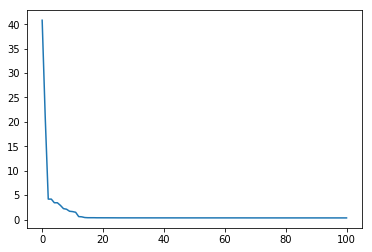

In [8]:
plt.plot(cpuNet.getErrors())

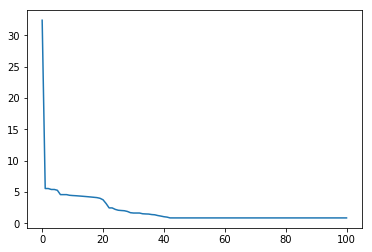

In [9]:
plt.plot(gpuNet.getErrors())

At this point I suspected something was wrong with my implementation, but I continued on to try out how it would do on my A5 code as I knew what sort of values to expect from that. 

In [10]:
# testing with a5 data...
csv = pd.read_csv("energydata_complete.csv")
#drop unneeded columns
csv = csv.drop(['date', 'rv1', 'rv2'], axis = 1)
data = csv.values #.values is a numpy array! 
Tenergy = data[:, :2]
Xenergy = data[:, 2:]

In [14]:
testNN = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
testNN.train(Xenergy, Tenergy, 10000) #300 should be fine
#Final error is not the same as RMSE


NeuralNetwork(24, [10, 10], 2)
   Network was trained for 10001 iterations. Final error is 4715.99911828145.

In [15]:
XenergyGPU = torch.from_numpy(Xenergy).cuda()
TenergyGPU = torch.from_numpy(Tenergy).cuda()
testNNGPU = nn.NeuralNetwork(XenergyGPU.shape[1], [10,10], TenergyGPU.shape[1], True)
testNNGPU.train(XenergyGPU, TenergyGPU, 10000) #300 should be fine
#Final error is not the same as RMSE

NeuralNetwork(24, [10, 10], 2)
   Network was trained for 10001 iterations. Final error is 10074.343105026634.

Above, you can see clearly that the error for the gpu implementation is much higher. I thought at first that it might just be an error with standardization that caused my numbers to seem higher than the results were, but the results varied wildly so went on to try a different strategy. 

Here I try implement this as a torch network. This was sort of a last ditch attempt to get something to work on the gpu. This definition of train is taken from the lecture code given to use. 

In [16]:
def train(X, T, learning_rate_hidden, learning_rate_output, nHiddens, nIterations):
    nSamples = X.shape[0]
    nOutputs = T.shape[1]

    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    V = 0.1*2*(np.random.uniform(size=(1+1, nHiddens))-0.5)
    W = 0.1*2*(np.random.uniform(size=(1+nHiddens ,nOutputs))-0.5)

    if not isinstance(X, np.ndarray):
        V = torch.from_numpy(V).cuda()
        W = torch.from_numpy(W).cuda()

    start_time = time.time()
    
    for step in range(nIterations):

        # Forward pass on training data
        if isinstance(X, np.ndarray):
            Z = np.tanh(X @ V[1:, :] + V[0:1, :])
        else:
            Z = (X @ V[1:, :] + V[0:1, :]).tanh()
        Y = Z @ W[1:, :] + W[0:1, :]

        # Error in output
        deltaW = (T - Y) / nSamples

        lrh = learning_rate_hidden
        lro = learning_rate_output
        # Backward pass - the backpropagation and weight update steps
        try:
            deltaV = (deltaW @ W[1:, :].T) * (1 - Z**2)
            V[1:, :] += lrh * X.T @ deltaV
            V[0:1, :] += lrh * deltaV.sum(0)
            W[1:, :] += lro * Z.T @ deltaW
            W[0:1, :] += lro * deltaW.sum()
        except:
            deltaV = (deltaW @ W[1:, :].t()) * (1 - Z**2)
            V[1:, :] += lrh * X.t() @ deltaV
            V[0:1, :] += lrh * deltaV.sum(0)
            W[1:, :] += lro * Z.t() @ deltaW
            W[0:1, :] += lro * deltaW.sum()
           
    print('train took', time.time() - start_time, 'seconds')
    
    return V, W
def use(X, V, W):
    if isinstance(X, np.ndarray):
        Z = np.tanh(X @ V[1:, :] + V[0:1, :])
    else:
        Z = (X @ V[1:, :] + V[0:1, :]).tanh()
    Y = Z @ W[1:, :] + W[0:1, :]
    return Y

In [21]:
V, W = train(Xenergy, Tenergy, 10, .01, 50, 100)

ValueError: shapes (19735,24) and (1,50) not aligned: 24 (dim 1) != 1 (dim 0)

In [24]:
def train_pytorch(X, T, learning_rate, nHiddens, nIterations, useAdam=False):
    
    class Torchnn(torch.nn.Module):
    
        def __init__(self, n_inputs, n_hidden_units, n_outputs):
            super(Torchnn, self).__init__()
            self.hidden = torch.nn.Linear(n_inputs, n_hidden_units) 
            self.tanh = torch.nn.Tanh()
            self.output = torch.nn.Linear(n_hidden_units, n_outputs)

        def forward(self, X):
            out = self.hidden(X)
            out = self.tanh(out)
            out = self.output(out)
            return out

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running on', device)
    
    torchnn = Torchnn(1, nHiddens, 1).to(device).double()  # default is single precision
    
    if useAdam:
        optimizer = torch.optim.Adam(torchnn.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(torchnn.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()
    
    errors = []
    startTime = time.time()

    for iteration in range(nIterations):
        # Forward pass
        outputs = torchnn(X)
        loss = loss_func(outputs, T)
        errors.append(torch.sqrt(loss))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Training took {} seconds'.format(time.time() - startTime))
    
    return torchnn, errors

In [25]:
torchnn, errors = train_pytorch(XenergyGPU, TenergyGPU, .01, 50, 100)

Running on cuda


RuntimeError: size mismatch, m1: [19735 x 24], m2: [1 x 50] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249

This is the end of the GPU section. As the last several code blocks show, this code is not able to handle different dimensions on input and output. I probably could have changed them to handle that, but I needed to start making progress at the end of break so I left this here. I did learn some about torch on GPUs though, so it was not a waste! 

### Representation of Board for Network

This section details how I created a neural network interpretable representation of the board state.

Here we import the board and piece representation created earlier in the project. These objects wrap up the board in a convenient way and provide methods for modify state and getting valid moves.

In [3]:
from board import *
from piece import *

Here we make a board with the starting state and a few checkers changed to kings to show their representation. On the top and left side of the board are the indexes of the moves to help the user view the state of the game.  

In [10]:
b = Board()
dr = b.draught
## add kings to show that they have *3 weight
blackKing = Piece(Color.BLACK, (0,1))
blackKing.king_me()
redKing = Piece(Color.RED, (7,6))
redKing.king_me()
dr[0, 1] = blackKing
dr[7, 6] = redKing
b.draught = dr
print(b)


      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | BK | -  | B  | -  | B  | -  | B 
 1 | B  | -  | B  | -  | B  | -  | B  | - 
 2 | -  | B  | -  | B  | -  | B  | -  | B 
 3 | -  | -  | -  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | R  | -  | R  | -  | R  | -  | R  | - 
 6 | -  | R  | -  | R  | -  | R  | -  | R 
 7 | R  | -  | R  | -  | R  | -  | RK | - 



Notice how almost half of the squares are empty. This is just part of the game of checkers. In the future, the board could not include these empty squares in the array to reduce space, but for this project that did not seem like a necessary optimization.

Here I show the representation of the board that is passed into the neural network. For traditional reinforcement learning, a (state,move) tuple is enough to store a unique dictionary input. Howerver, for a neural net, a vector representation of the same information is needed. To achieve this, I represent the board as a list of length 64, where enemy men are -1 and enemy kings are -3 to let the network differentiate between the two. The friendly players are differentiated by 1 and 3 as well. Then, I add the move to the end as four numbers representing form , to. 

In [12]:
moves = b.validMoves()
print("The first of valid moves is seen easily in the board, from 0,5 to 4,1")
print(moves)
vector = b.stateMoveVectorForNN(moves[0])
len(vector)
#shows a vector representation of the board for the neural network.
#see newStateRep in notebook 20(?) for more. 


The first of valid moves is seen easily in the board, from 0,5 to 4,1
[((5, 0), ((4, 1),)), ((5, 2), ((4, 1),)), ((5, 2), ((4, 3),)), ((5, 4), ((4, 3),)), ((5, 4), ((4, 5),)), ((5, 6), ((4, 5),)), ((5, 6), ((4, 7),))]


68

## Reinforcement Learning With a Neural Network

This section details the implementation of the nueral network. This network and training structure is based off of a combination of notebooks 15 and 21, which give code and explanaitions detailing reinforcement learning with neural nets. I took the explanation of adversarial reinforcement learning in 15 and combined it with the implementation of neural network based reinforcement learning in 21. 

### Structure
Above I showed the input structure of the Neural Network to be a vector of length 68 representing the state and move. The output of the neural network will be a number from -1 to 1 representing the q value for the state and move. Selecting the best move would mean selecting the move that has the highest q value. In order to train this then, the states and values are passed in and trained to get the value of the move(found by playing games) as output. 

### Implementation 

The implementation of neural network based reinforcement learning is made in NeuralReinforcement.py. This file has the following methods:
* `epsilonGreedy(Qnet, state, epsilon)`
* `finished(state)`
* `trainQnet(nBatches, nRepsPerBatch, hiddenLayers, nIterations, nReplays, epsilon, epsilonDecayFactor)`
* `useQ(Qnet, maxSteps, printResult = False)`
* `testQ(Qnet, trials, maxSteps = 1000, printResult = False)`
* `plotOutcomes(outcomes, binRate = 10)`

`epsilonGreedy(Qnet, state, epsilon)` takes a Qnet neural network object, the state as a Board object, and the value for epsilon as a number from 0 to 1. `epsilonGreedy` is a function that either takes a random move or the move decided by Qnet based on the value of epsilon. If a randomly generated number is less than `epsilon`, the function just returns a randomly selected move from the valid moves given by `state`. Otherwise, it decides using `Qnet`. Every valid move in the given `state` is passed in along with `state` as input the the neural network `Qnet`, then the move with the highest output is selected as the best move and returned.

`finished(state)` simply takes a state and returns a boolean for whether the game is finished or not based on the number of valid moves remaining for the given player.

`trainQnet(nBatches, nRepsPerBatch, hiddenLayers, nIterations, nReplays, epsilon, epsilonDecayFactor)` is the most complicated method in the file. It takes:
* `nBatches` which represents the number of batches to train the neural network with.
* `nRepsPerBatch` which represents the number of games to play per batch to train with.
* `hiddenLayers` gives the structure of the neural network in the list form [#HiddenUnitsInLayer1, #HiddenUnitsInLayer2, ..., #HiddenLayerUnitsInLayern].
* `nIterations` is the number of iterations on which to train the neural net.
* `nReplays` is the number of replays to used for training, but I never got around to using it in the scope of this project.
* `epsilon` gives the initial epsilon, or amount of random moves, to be used for training. 
* `epsilonDecayFactor` is the amount to decay `epsilon` by for each batch in `nBatches`

The method works in the following way.

* First, initialize 68 to 1 neural network with `hiddenLayers` structure as well as variables to store training information
* For the number of batches in `nBatches`
    * If after the first batch, decay epsilon. Create a list to hold the samples
    * For number of repititions in `nRepititions`
        * Take a first move given by `epsilonGreedy`
        * While the game is not finished:
            * Create variables for the new state and move and initialize reinforcement and Q values
            * If the game is finished, set positive reinforcement for game.
            * Otherwise, let black take a move and see if they win. If they do, add a negative reinforcement. 
            * At the end, add the game and reinforcement to samples
            * Then, take the `epsilonGreedy` move and move new state and moves to the old ones. 
    * Train the neural net on the information gathered after the previous repititions. 
* Return Qnet

* `useQ(Qnet, maxSteps, printResult = False)` plays a game using the greedy choices based on Qnet against a random opponent with `maxSteps` as a cutoff. If printResult is True, it also returns a list of states. Otherwise it returns 0 or 1 for a loss or a win. 
* `testQ(Qnet, trials, maxSteps = 1000, printResult = False)` calls `useQ` for number of trails to roughly estimate the performance of Qnet against a random opponent.
* `plotOutcomes(outcomes, binRate = 10)` plots the outcomes of training a neural network. 

### Using and Testing The Neural Net
The following section details my procedure for testing different network structures and my evaluation of their success. 

Here we import several packages that are needed. `NeuralReinforcement` contains the implementaion. nnutils is a utility file that contains helper methods described bellow. The rest of the imports are utilities to timing or other small methods in this notebook. 

In [21]:
import NeuralReinforcement as nr
import nnutils 
import numpy as np
import time
import datetime
import random
from board import *

`nnutils` contains some helping functions. 

* `loadNetwork(filename)` reads in a Qnet named "filename" from the disk and returns it as an object. Reads from directory qnets/.
* `saveNetwork(filename, Qnet)` saves a Qnet object as "filename" in directory qnets/
* `trainNN(nBatches, nRepsPerbatch, hiddenLayers, nIterations, epsilonDecayFactor)` trains and times a neural net given the specified parameters. 
* `randomQ(maxSteps)` simulates a game of two random players against each other. Used to compare our strategies to a "stupid" strategy. 

I tested the neural nets itermitently over a few weeks. I was not getting great results at first, starting with win rates at 55%, and eventually getting my best at 70%. But during one of the presentations in the last week, someone had a huge network structure, so I decided to try that. That plus fewer iterations improved performance more, eventually getting up to an 87% win rate! I also found that very few batches with a lot of reps was more favorable. My best win rate was with a 1000 hidden unit network trained on 1000 games that won around 99% of games against a random opponent!

Here I will show the the performance of my first structures and some simple structures. Then show the better ones. All of the Qnets will be saved using `dill` and put in a the director `qnets/` so they can be used without retraining. Later in the notebook I will discuss why I chose the different structures and parameters, but for now these examples just illustrate trails from different points of my progress. 

In [26]:
try:
    qnet68 = nnutils.loadNetwork("68.qnet")
except:
    qnet68 = nnutils.trainNN(20, 10, [68], 10, .97)
    saveNetwork("68.qnet", qnet68)

In [28]:
res = nr.testQ(qnet68, 1000, maxSteps = 1500)

Red won 62.40% of games!


In [29]:
try:
    qnet50_50_5020x10 = nnutils.loadNetwork("50_50_5020x10.qnet")
except:
    qnet50_50_5020x10 = nnutils.trainNN(20, 10, [50, 50, 50], 10, .97)
    saveNetwork("50_50_5020x10.qnet", qnet50_50_5020x10)

In [9]:
res = nr.testQ(qnet50_50_5020x10, 1000, maxSteps = 1500)

Red won 57.40% of games!


In [30]:
try:
    qnet50_50_50 = nnutils.loadNetwork("50_50_50.qnet")
except:
    qnet50_50_50 = nnutils.trainNN(2, 100, [50, 50, 50], 10, .97)
    saveNetwork("50_50_50.qnet", qnet50_50_50)

In [13]:
res = nr.testQ(qnet50_50_50, 1000, maxSteps = 1500)

Red won 65.80% of games!


This takes around two minutes to train and gets a respectable win rate. 

In [31]:
try:
    qnet100_100 = nnutils.loadNetwork("100_100.qnet")
except:
    qnet100_100 = nnutils.trainNN(2, 100, [100,100], 10, .97)
    saveNetwork("100_100.qnet", qnet100_100)

In [30]:
res = nr.testQ(qnet100_100, 1000, maxSteps = 1500)

Red won 82.10% of games!


This is the go big or go home network, trained on 1000 games with 1000 hidden units. It trained for five hours on my 8 core cpu, so I'm glad these networks can be saved! Ended up with strong results. 

In [37]:
try:
    qnet1000 = nnutils.loadNetwork("1000.qnet")
except:
    qnet1000 = nnutils.trainNN(2, 500, [1000], 10, .97)
    saveNetwork("1000.qnet", qnet1000)

In [42]:
res = nr.testQ(qnet1000, 1000, maxSteps = 1500)

Red won 98.20% of games!


Looks like 5 hours of training was worth it!

Here I plot the outcomes of one of the trained neural nets. As I will explain later though, there were not enough batches to have epsilon greedy start choosing good moves, so the graph does not make much progress. 

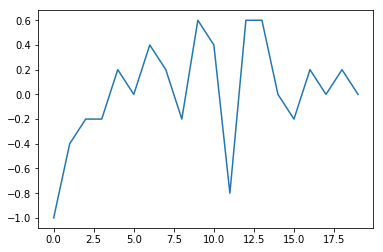

In [33]:
nnutils.plotOutcomes(qnet50_50_5020x10.outcomes)

Here I demonstrate what the q values look like from the neural network. 

In [34]:
# create a demonstration board
b = Board()

In [35]:
moves = b.validMoves()

Here we print out all of the Q values for the starting state of the game.

In [38]:
for move in moves:
    X = b.stateMoveVectorForNN(move)
    # without this, we give it a list. Needs an np array.
    X = np.array(X)
    # expects a 2d array. We want one row of a that array, so reshape first.
    X = X.reshape(1, 68)
    print(qnet1000.use(X))

[[0.02078446]]
[[0.02232421]]
[[0.0392772]]
[[0.04072942]]
[[0.03672907]]
[[0.03459328]]
[[0.01826239]]


In [39]:
nr.epsilonGreedy(qnet1000, b, 0)

(((5, 4), ((4, 3),)), 0.04072942055390925)

Here we can see the results of the 1000 unit neural network. While the reinforcement values are fairly sparse, output can be found for every state of the game. Next we verify that there isn't a bias in checkers that leads red to win to see if the 99% win rate is notable. We play random moves against each other to check to see that red wins around 50% of the time.

In [41]:
random_wins = []
for _ in range(100):
    random_wins.append(nnutils.randomQ(1000))

In [42]:
np.mean(random_wins)

0.49

The above trial shows that random players against each other do in fact win against each other at a rate of 50%. This means that win rates significantly above 50% indicate that the network has learned some sort of strategy (although as noted elsewhere, simply picking the first move in valid_moves can lead to win rates as high as 98%). 

### Results of Neural Network
The samples above show only some of the structures I tried. The very fist call I made was with this (30, 100, [50, 50, 50], 20, 0, 1, .99) call. This produced a valid neural network which won a measly 55.85% of the time after an hour and a half of training. But because I had done trails with `randomQ` I knew that the network had learned something. I looked through the code and found a few bugs that would improve my run time, including a bug that meant I was accidentally training for both black and red players. But even with that and different network structures, the networks could not do much better than a 60% win rate when called with the same other parameters. What I eventually found was that tweaking the number of iterations, batches and reps could actually make a large difference in effectiveness. Very low batch and iteration counts, like 2 and 10 respectively in conjuction with high rep counts in the hundreds of games gave much more effective training. This is counter intuitive, as it almost negates the role of epsilon decay factor as the first few games are essentially random moves. However, this strategy resulted in the most effective results.

### Observations and Setbacks

The first setback I had was with getting some sort of code to run on the GPU. I had figured it would be a simple matter of changing a few lines of code to work with pytorch tensors, but I found it to be more complex than that. Looking back, I should have tried a few simple cases with writing my own neural net code in pytorch to more fully grasp the difference between that and the class neural network code. 

The next observation I had was with implementing the code. What was difficult here was determining what I was actually training the neural network on and what values it needed to target. I found that training was more successful with very few batches, most likely because of the number of iterations used to train the neural network. 

The biggest setback I had was probably due to time. Training these networks takes awhile on the GPU, so trying out many different large structures was not easy or feasible to do. In the end I tried a few smaller structures and guessed about what my be an effective large structure to see how it would tun. In the end it seemed to be fairly effective, winning a large portion of games consistently. 

In [3]:
import io
from nbformat import current
import glob
nbfile = glob.glob('Williams-Newell-Haynes-Final-Project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Williams-Newell-Haynes-Final-Project.ipynb is 8262


## Overall Observations